## 난임 환자 대상 임신 성공 여부 예측

## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [468]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import optuna

In [469]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [470]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [471]:
import pandas as pd

# 데이터 로드
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['ID', '시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형',
       '특정_시술_유형', '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부

In [472]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술_시기_코드               256351 non-null  object 
 2   시술_당시_나이               256351 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 4   시술_유형                  256351 non-null  object 
 5   특정_시술_유형               256349 non-null  object 
 6   배란_자극_여부               256351 non-null  int64  
 7   배란_유도_유형               256351 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             256351 non-null  int64  
 12  남성_부_불임_원인             256351 non-null  int64  
 13  여성_주_불임_원인             256351 non-null  int64  
 14  여성_부_불임_원인             256351 non-nu

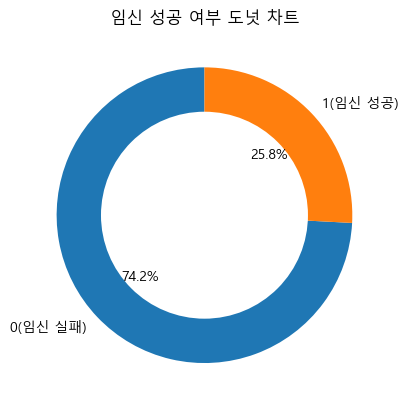

In [473]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [474]:
# '시술_유형' 변수의 값이 'DI'에 해당 안하는 데이터 추출
DI_train = train[train['시술_유형'] == 'DI'] 
DI_test = test[test['시술_유형'] == 'DI']

# 모든 값이 결측값인 변수를 제거
DI_train = DI_train.dropna(axis=1, how='all')
DI_test = DI_test.dropna(axis=1, how='all')

train = DI_train
test = DI_test

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [475]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1    0    1  Total
variable                                     
TRCMWS    0.862981  0.137019  718  114    832
TRDQAZ    0.887967  0.112033  856  108    964
TRJXFG    0.886770  0.113230  744   95    839
TRVNRY    0.877426  0.122574  859  120    979
TRXQMD    0.837808  0.162192  749  145    894
TRYBLT    0.865811  0.134189  742  115    857
TRZKPL    0.876890  0.123110  812  114    926


### 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [476]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
만18-34세   0.805408  0.194592  1668  403   2071
만35-37세   0.848966  0.151034  1231  219   1450
만38-39세   0.897436  0.102564   945  108   1053
만40-42세   0.930502  0.069498   964   72   1036
만43-44세   0.980907  0.019093   411    8    419
만45-50세   0.996183  0.003817   261    1    262


In [477]:
test['시술_당시_나이'].value_counts()

만18-34세    680
만35-37세    524
만38-39세    383
만40-42세    355
만43-44세    149
만45-50세     85
Name: 시술_당시_나이, dtype: int64

### 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [478]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       1.000000  0.000000   2.0  0.0      2
3.0       0.666667  0.333333   6.0  3.0      9
4.0       0.700000  0.300000   7.0  3.0     10
5.0       0.785714  0.214286  11.0  3.0     14
6.0       0.852941  0.147059  29.0  5.0     34
7.0       0.727273  0.272727  24.0  9.0     33
8.0       0.853659  0.146341  35.0  6.0     41
9.0       0.965517  0.034483  28.0  1.0     29
10.0      0.774194  0.225806  24.0  7.0     31
11.0      0.862069  0.137931  25.0  4.0     29
12.0      0.863636  0.136364  19.0  3.0     22
13.0      0.888889  0.111111  16.0  2.0     18
14.0      0.800000  0.200000   8.0  2.0     10
15.0      0.800000  0.200000   4.0  1.0      5
16.0      1.000000  0.000000   1.0  0.0      1
17.0      0.833333  0.166667   5.0  1.0      6
18.0      1.000000  0.000000   2.0  0.0      2
19.0      0.666667  0.333333   2.0  1.0      3
20.0      1.000000

In [479]:
# 결측값 개수 확인
print("결측값 개수:", train['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum())

# 결측값을 unknown으로 채우기
train['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum())

결측값 개수: 5988
결측값 개수: 0


In [480]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
1.0       1.000000  0.000000     2.0    0.0      2
3.0       0.666667  0.333333     6.0    3.0      9
4.0       0.700000  0.300000     7.0    3.0     10
5.0       0.785714  0.214286    11.0    3.0     14
6.0       0.852941  0.147059    29.0    5.0     34
7.0       0.727273  0.272727    24.0    9.0     33
8.0       0.853659  0.146341    35.0    6.0     41
9.0       0.965517  0.034483    28.0    1.0     29
10.0      0.774194  0.225806    24.0    7.0     31
11.0      0.862069  0.137931    25.0    4.0     29
12.0      0.863636  0.136364    19.0    3.0     22
13.0      0.888889  0.111111    16.0    2.0     18
14.0      0.800000  0.200000     8.0    2.0     10
15.0      0.800000  0.200000     4.0    1.0      5
16.0      1.000000  0.000000     1.0    0.0      1
17.0      0.833333  0.166667     5.0    1.0      6
18.0      1.000000  0.000000     2.0    

### 4. 시술_유형

IVF 또는 DI 시술 여부

In [481]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
DI        0.871086  0.128914  5480  811   6291


In [482]:
test['시술_유형'].value_counts()

DI    2176
Name: 시술_유형, dtype: int64

IVF 와 DI 시술중 IVF 시술 데이터만 제공됨

In [483]:
# '시술_유형' 변수 제거
train = train.drop(columns=['시술_유형'])
test = test.drop(columns=['시술_유형'])

### 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [484]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

        group  '임신_성공_여부' count     ratio  Total
0        GIFT                 0  0.000000      1
1  Generic DI                12  0.169014     71
2         ICI                13  0.135417     96
3         IUI               784  0.128525   6100
4         IVI                 2  0.086957     23


In [485]:
test['특정_시술_유형'].value_counts()

IUI           2112
ICI             28
Generic DI      26
IVI              8
IUI:ICI          2
Name: 특정_시술_유형, dtype: int64

In [486]:
# '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['FER', 'GIFT'])]
# test = test.loc[~test['특정_시술_유형'].isin(['FER', 'GIFT'])]

In [487]:
# 시술 유형 변환 함수
def transform_treatment(treatment):
    if isinstance(treatment, str):  # treatment가 문자열인지 확인
        if treatment.startswith("ICSI"):
            if "AH" in treatment:
                return "ICSI / AH"
            elif "BLASTOCYST" in treatment:
                return "ICSI / BLASTOCYST"
            return "ICSI"
        elif treatment.startswith("IVF"):
            if "AH" in treatment:
                return "IVF / AH"
            elif "BLASTOCYST" in treatment:
                return "IVF / BLASTOCYST"
            return "IVF"
        elif treatment == "IUI:ICI":
            return "IUI"
    return treatment  # 기타 시술은 그대로 반환

# 변환된 열 추가
train['변환된_특정_시술_유형'] = train['특정_시술_유형'].apply(transform_treatment)
test['변환된_특정_시술_유형'] = test['특정_시술_유형'].apply(transform_treatment)

In [488]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                   0         1     0    1  Total
variable                                        
Generic DI  0.830986  0.169014    59   12     71
ICI         0.864583  0.135417    83   13     96
IUI         0.871475  0.128525  5316  784   6100
IVI         0.913043  0.086957    21    2     23


In [489]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                   0         1     0    1  Total
variable                                        
Generic DI  0.830986  0.169014    59   12     71
ICI         0.864583  0.135417    83   13     96
IUI         0.871475  0.128525  5316  784   6100
IVI         0.913043  0.086957    21    2     23


In [490]:
test['변환된_특정_시술_유형'].value_counts()

IUI           2114
ICI             28
Generic DI      26
IVI              8
Name: 변환된_특정_시술_유형, dtype: int64

In [491]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['특정_시술_유형'])
test = test.drop(columns=['특정_시술_유형'])

### 6. 배란_자극_여부

배란 자극 치료가 사용되었는지 여부

In [492]:
value_counts_ratio(train, '배란_자극_여부')


배란_자극_여부별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.882529  0.117471  2652  353   3005
1         0.860578  0.139422  2827  458   3285


### 7. 배란_유도_유형

사용된 배란 유도 방법 유형

In [493]:
value_counts_ratio(train, '배란_유도_유형')


배란_유도_유형별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
알 수 없음    0.871065  0.128935  5479  811   6290


In [494]:
test['배란_유도_유형'].value_counts()

알 수 없음    2176
Name: 배란_유도_유형, dtype: int64

In [495]:
# 결측값 개수 확인
print("결측값 개수:", train['배란_유도_유형'].isnull().sum())

결측값 개수: 0


In [496]:
# 변수 제거
train = train.drop(columns=['배란_유도_유형'])
test = test.drop(columns=['배란_유도_유형'])

### 8. 단일_배아_이식_여부

선택적으로 단일 배아를 이식했는지 여부

In [497]:
# value_counts_ratio(train, '단일_배아_이식_여부') -> 모든값이 결측

### 9. 착상_전_유전_검사_사용_여부

PGS(착상 전 유전 검사)가 시행되었는지 여부

In [498]:
# value_counts_ratio(train, '착상_전_유전_검사_사용_여부')  -> 모든값이 결측

### 10. 착상_전_유전_진단_사용_여부

PGD(착상 전 유전 진단)가 시행되었는지 여부

In [499]:
# value_counts_ratio(train, '착상_전_유전_진단_사용_여부')  -> 모든값이 결측

### 11. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [500]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.874250  0.125750  5249  755   6004
1         0.804196  0.195804   230   56    286


### 12. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [501]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871067  0.128933  5371  795   6166
1         0.870968  0.129032   108   16    124


### 13. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [502]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.873895  0.126105  5142  742   5884
1         0.830049  0.169951   337   69    406


### 14. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [503]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871429  0.128571  5368  792   6160
1         0.853846  0.146154   111   19    130


### 15. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [504]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.874894  0.125106  5182  741   5923
1         0.809264  0.190736   297   70    367


### 16. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [505]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871144  0.128856  5422  802   6224
1         0.863636  0.136364    57    9     66


### 17. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [506]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.868226  0.131774  5047  766   5813
1         0.905660  0.094340   432   45    477


### 18. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [507]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.870433  0.129567  5408  805   6213
1         0.922078  0.077922    71    6     77


### 19. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [508]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.895925  0.104075  3056  355   3411
1         0.841612  0.158388  2423  456   2879


### 20. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [509]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871192  0.128808  5147  761   5908
1         0.869110  0.130890   332   50    382


### 21. 불임_원인_-_여성_요인

여성 요인으로 인한 불임 여부

In [510]:
value_counts_ratio(train, '불임_원인_-_여성_요인')


불임_원인_-_여성_요인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871065  0.128935  5479  811   6290


In [511]:
# 변수 제거
train = train.drop(columns=['불임_원인_-_여성_요인'])
test = test.drop(columns=['불임_원인_-_여성_요인'])

### 22. 불임_원인_-_자궁경부_문제

자궁경부 이상으로 인한 불임 여부

In [512]:
value_counts_ratio(train, '불임_원인_-_자궁경부_문제')


불임_원인_-_자궁경부_문제별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871065  0.128935  5479  811   6290


In [513]:
# 변수 제거
train = train.drop(columns=['불임_원인_-_자궁경부_문제'])
test = test.drop(columns=['불임_원인_-_자궁경부_문제'])

### 23. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [514]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.869757  0.130243  5329  798   6127
1         0.920245  0.079755   150   13    163


### 24. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [515]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871541  0.128459  5448  803   6251
1         0.794872  0.205128    31    8     39


In [516]:
test['불임_원인_-_정자_농도'].value_counts()

0    2165
1      11
Name: 불임_원인_-_정자_농도, dtype: int64

### 25. 불임_원인_-_정자_면역학적_요인

파트너의 정자 면역 관련 문제 여부

In [517]:
value_counts_ratio(train, '불임_원인_-_정자_면역학적_요인')


불임_원인_-_정자_면역학적_요인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871065  0.128935  5479  811   6290


In [518]:
# 변수 제거
train = train.drop(columns=['불임_원인_-_정자_면역학적_요인'])
test = test.drop(columns=['불임_원인_-_정자_면역학적_요인'])

### 26. 불임_원인_-_정자_운동성

파트너의 정자 운동성 문제 여부

In [519]:
value_counts_ratio(train, '불임_원인_-_정자_운동성')


불임_원인_-_정자_운동성별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871065  0.128935  5479  811   6290


In [520]:
# 변수 제거
train = train.drop(columns=['불임_원인_-_정자_운동성'])
test = test.drop(columns=['불임_원인_-_정자_운동성'])

### 27. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [521]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0         0.871024  0.128976  5477.0  811.0   6288
1         1.000000  0.000000     2.0    0.0      2


In [522]:
test['불임_원인_-_정자_형태'].value_counts()

0    2176
Name: 불임_원인_-_정자_형태, dtype: int64

In [523]:
# 변수 제거
train = train.drop(columns=['불임_원인_-_정자_형태'])
test = test.drop(columns=['불임_원인_-_정자_형태'])

In [524]:
# # '불임_원인_-_정자_형태' 값이 1인 행 삭제
# train = train[train['불임_원인_-_정자_형태'] != 1]
# test = test[test['불임_원인_-_정자_형태'] != 1]

### 28. 배아_생성_주요_이유

배아 생성의 주된 목적(시술, 보관 등)

In [525]:
# value_counts_ratio(train, '배아_생성_주요_이유')  -> 모든값이 결측

### 29. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [526]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.926768  0.073232   367   29    396
1회        0.865406  0.134594   778  121    899
2회        0.866184  0.133816   958  148   1106
3회        0.876923  0.123077   912  128   1040
4회        0.853685  0.146315   776  133    909
5회        0.870095  0.129905   643   96    739
6회 이상     0.870108  0.129892  1045  156   1201


In [527]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_시술_횟수'] = train['총_시술_횟수'].map(mapping)
test['총_시술_횟수'] = test['총_시술_횟수'].map(mapping)

value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.926768  0.073232   367   29    396
1         0.865406  0.134594   778  121    899
2         0.866184  0.133816   958  148   1106
3         0.876923  0.123077   912  128   1040
4         0.853685  0.146315   776  133    909
5         0.870095  0.129905   643   96    739
6         0.870108  0.129892  1045  156   1201


In [528]:
test['총_시술_횟수'].value_counts()

6    421
3    375
1    351
2    346
4    285
5    265
0    133
Name: 총_시술_횟수, dtype: int64

### 30. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [529]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.894336  0.105664   821   97    918
1회        0.870229  0.129771  1026  153   1179
2회        0.872414  0.127586  1012  148   1160
3회        0.875135  0.124865   813  116    929
4회        0.867758  0.132242   689  105    794
5회        0.865079  0.134921   545   85    630
6회 이상     0.842647  0.157353   573  107    680


In [530]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['클리닉_내_총_시술_횟수'] = train['클리닉_내_총_시술_횟수'].map(mapping)
test['클리닉_내_총_시술_횟수'] = test['클리닉_내_총_시술_횟수'].map(mapping)

value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.894336  0.105664   821   97    918
1         0.870229  0.129771  1026  153   1179
2         0.872414  0.127586  1012  148   1160
3         0.875135  0.124865   813  116    929
4         0.867758  0.132242   689  105    794
5         0.865079  0.134921   545   85    630
6         0.842647  0.157353   573  107    680


### 31. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [531]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.861111  0.138889  3224  520   3744
1회        0.871795  0.128205   816  120    936
2회        0.898990  0.101010   534   60    594
3회        0.878282  0.121718   368   51    419
4회        0.892720  0.107280   233   28    261
5회        0.921212  0.078788   152   13    165
6회 이상     0.888889  0.111111   152   19    171


In [532]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_시술_횟수'] = train['IVF_시술_횟수'].map(mapping)
test['IVF_시술_횟수'] = test['IVF_시술_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.861111  0.138889  3224  520   3744
1         0.871795  0.128205   816  120    936
2         0.898990  0.101010   534   60    594
3         0.878282  0.121718   368   51    419
4         0.892720  0.107280   233   28    261
5         0.921212  0.078788   152   13    165
6         0.888889  0.111111   152   19    171


### 32. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [533]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.900973  0.099027  1019  112   1131
1회        0.873262  0.126738  1068  155   1223
2회        0.860793  0.139207   977  158   1135
3회        0.871397  0.128603   786  116    902
4회        0.857542  0.142458   614  102    716
5회        0.890435  0.109565   512   63    575
6회 이상     0.827303  0.172697   503  105    608


In [534]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['DI_시술_횟수'] = train['DI_시술_횟수'].map(mapping)
test['DI_시술_횟수'] = test['DI_시술_횟수'].map(mapping)

value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.900973  0.099027  1019  112   1131
1         0.873262  0.126738  1068  155   1223
2         0.860793  0.139207   977  158   1135
3         0.871397  0.128603   786  116    902
4         0.857542  0.142458   614  102    716
5         0.890435  0.109565   512   63    575
6         0.827303  0.172697   503  105    608


### 33. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [535]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0회        0.902511  0.097489  3379.0  365.0   3744
1회        0.830102  0.169898  1798.0  368.0   2166
2회        0.785933  0.214067   257.0   70.0    327
3회        0.847826  0.152174    39.0    7.0     46
4회        1.000000  0.000000     6.0    0.0      6
5회        0.000000  1.000000     0.0    1.0      1


In [536]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_임신_횟수'] = train['총_임신_횟수'].map(mapping)
test['총_임신_횟수'] = test['총_임신_횟수'].map(mapping)

value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0         0.902511  0.097489  3379.0  365.0   3744
1         0.830102  0.169898  1798.0  368.0   2166
2         0.785933  0.214067   257.0   70.0    327
3         0.847826  0.152174    39.0    7.0     46
4         1.000000  0.000000     6.0    0.0      6
5         0.000000  1.000000     0.0    1.0      1


### 34. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [537]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0회        0.869543  0.130457  5099.0  765.0   5864
1회        0.888041  0.111959   349.0   44.0    393
2회        0.935484  0.064516    29.0    2.0     31
3회        1.000000  0.000000     2.0    0.0      2


In [538]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_임신_횟수'] = train['IVF_임신_횟수'].map(mapping)
test['IVF_임신_횟수'] = test['IVF_임신_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0         0.869543  0.130457  5099.0  765.0   5864
1         0.888041  0.111959   349.0   44.0    393
2         0.935484  0.064516    29.0    2.0     31
3         1.000000  0.000000     2.0    0.0      2


### 35. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [539]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0회        0.900752  0.099248  3712.0  409.0   4121
1회        0.823656  0.176344  1532.0  328.0   1860
2회        0.752809  0.247191   201.0   66.0    267
3회        0.810811  0.189189    30.0    7.0     37
4회        1.000000  0.000000     4.0    0.0      4
5회        0.000000  1.000000     0.0    1.0      1


In [540]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['DI_임신_횟수'] = train['DI_임신_횟수'].map(mapping)
test['DI_임신_횟수'] = test['DI_임신_횟수'].map(mapping)

value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0         0.900752  0.099248  3712.0  409.0   4121
1         0.823656  0.176344  1532.0  328.0   1860
2         0.752809  0.247191   201.0   66.0    267
3         0.810811  0.189189    30.0    7.0     37
4         1.000000  0.000000     4.0    0.0      4
5         0.000000  1.000000     0.0    1.0      1


### 36. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [541]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.899191  0.100809  3889  436   4325
1회        0.809258  0.190742  1451  342   1793
2회        0.801325  0.198675   121   30    151
3회        0.857143  0.142857    18    3     21


In [542]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_출산_횟수'] = train['총_출산_횟수'].map(mapping)
test['총_출산_횟수'] = test['총_출산_횟수'].map(mapping)

value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.899191  0.100809  3889  436   4325
1         0.809258  0.190742  1451  342   1793
2         0.801325  0.198675   121   30    151
3         0.857143  0.142857    18    3     21


### 37. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [543]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.870367  0.129633  5237  780   6017
1회        0.890566  0.109434   236   29    265
2회        0.750000  0.250000     6    2      8


In [544]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_출산_횟수'] = train['IVF_출산_횟수'].map(mapping)
test['IVF_출산_횟수'] = test['IVF_출산_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.870367  0.129633  5237  780   6017
1         0.890566  0.109434   236   29    265
2         0.750000  0.250000     6    2      8


### 38. DI_출산_횟수

DI 시술로 출산한 횟수

In [545]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.898298  0.101702  4116  466   4582
1회        0.797558  0.202442  1241  315   1556
2회        0.800000  0.200000   108   27    135
3회        0.823529  0.176471    14    3     17


In [546]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['DI_출산_횟수'] = train['DI_출산_횟수'].map(mapping)
test['DI_출산_횟수'] = test['DI_출산_횟수'].map(mapping)

value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.898298  0.101702  4116  466   4582
1         0.797558  0.202442  1241  315   1556
2         0.800000  0.200000   108   27    135
3         0.823529  0.176471    14    3     17


In [547]:
# # IVF 및 DI 관련 임신 및 출산 비율 계산

# # 임신 시술 비율
# train['IVF_임신_시술_비율'] = train['IVF_임신_횟수'] / train['IVF_시술_횟수'].replace(0, np.nan)
# train['DI_임신_시술_비율'] = train['DI_임신_횟수'] / train['DI_시술_횟수'].replace(0, np.nan)
# train['총_임신_시술_비율'] = train['총_임신_횟수'] / train['총_시술_횟수'].replace(0, np.nan)

# # 출산 시술 비율
# train['IVF_출산_시술_비율'] = train['IVF_출산_횟수'] / train['IVF_시술_횟수'].replace(0, np.nan)
# train['DI_출산_시술_비율'] = train['DI_출산_횟수'] / train['DI_시술_횟수'].replace(0, np.nan)
# train['총_출산_시술_비율'] = train['총_출산_횟수'] / train['총_시술_횟수'].replace(0, np.nan)

# # 출산-임신 비율
# train['IVF_출산_임신_비율'] = train['IVF_출산_횟수'] / train['IVF_임신_횟수'].replace(0, np.nan)
# train['DI_출산_임신_비율'] = train['DI_출산_횟수'] / train['DI_임신_횟수'].replace(0, np.nan)
# train['총_출산_임신_비율'] = train['총_출산_횟수'] / train['총_임신_횟수'].replace(0, np.nan)

# # 클리닉 내 IVF 및 DI 비율
# train['IVF_비율'] = train['IVF_시술_횟수'] / train['클리닉_내_총_시술_횟수'].replace(0, np.nan)
# train['DI_비율'] = train['DI_시술_횟수'] / train['클리닉_내_총_시술_횟수'].replace(0, np.nan)

# # 성공률 계산
# train['임신_성공률'] = train['총_임신_횟수'] / train['총_시술_횟수'].replace(0, np.nan)
# train['출산_성공률'] = train['총_출산_횟수'] / train['총_임신_횟수'].replace(0, np.nan)

# # 비율 계산 (IVF 대비 DI 비율 등)
# train['DI_비율_IVF_대비'] = train['DI_시술_횟수'] / train['IVF_시술_횟수'].replace(0, np.nan)
# train['출산_효율성'] = train['총_출산_횟수'] / train['IVF_시술_횟수'].replace(0, np.nan)
# train['임신_효율성'] = train['총_임신_횟수'] / train['DI_시술_횟수'].replace(0, np.nan)
# train['경과_시술_횟수_변화'] = train['총_시술_횟수'] - (train['IVF_시술_횟수'] + train['DI_시술_횟수'])

# # test 데이터프레임에도 동일한 계산 적용
# test['IVF_임신_시술_비율'] = test['IVF_임신_횟수'] / test['IVF_시술_횟수'].replace(0, np.nan)
# test['DI_임신_시술_비율'] = test['DI_임신_횟수'] / test['DI_시술_횟수'].replace(0, np.nan)
# test['총_임신_시술_비율'] = test['총_임신_횟수'] / test['총_시술_횟수'].replace(0, np.nan)

# test['IVF_출산_시술_비율'] = test['IVF_출산_횟수'] / test['IVF_시술_횟수'].replace(0, np.nan)
# test['DI_출산_시술_비율'] = test['DI_출산_횟수'] / test['DI_시술_횟수'].replace(0, np.nan)
# test['총_출산_시술_비율'] = test['총_출산_횟수'] / test['총_시술_횟수'].replace(0, np.nan)

# test['IVF_출산_임신_비율'] = test['IVF_출산_횟수'] / test['IVF_임신_횟수'].replace(0, np.nan)
# test['DI_출산_임신_비율'] = test['DI_출산_횟수'] / test['DI_임신_횟수'].replace(0, np.nan)
# test['총_출산_임신_비율'] = test['총_출산_횟수'] / test['총_임신_횟수'].replace(0, np.nan)

# test['IVF_비율'] = test['IVF_시술_횟수'] / test['클리닉_내_총_시술_횟수'].replace(0, np.nan)
# test['DI_비율'] = test['DI_시술_횟수'] / test['클리닉_내_총_시술_횟수'].replace(0, np.nan)

# test['임신_성공률'] = test['총_임신_횟수'] / test['총_시술_횟수'].replace(0, np.nan)
# test['출산_성공률'] = test['총_출산_횟수'] / test['총_임신_횟수'].replace(0, np.nan)

# test['DI_비율_IVF_대비'] = test['DI_시술_횟수'] / test['IVF_시술_횟수'].replace(0, np.nan)
# test['출산_효율성'] = test['총_출산_횟수'] / test['IVF_시술_횟수'].replace(0, np.nan)
# test['임신_효율성'] = test['총_임신_횟수'] / test['DI_시술_횟수'].replace(0, np.nan)
# test['경과_시술_횟수_변화'] = test['총_시술_횟수'] - (test['IVF_시술_횟수'] + test['DI_시술_횟수'])


### 39. 총_생성_배아_수

해당 시술에서 생성된 배아의 총 개수

In [548]:
# value_counts_ratio(train, '총_생성_배아_수')  -> 모든값이 결측

### 40. 미세주입된_난자_수

정자 미세주입(ICSI)으로 처리된 난자의 수

In [549]:
# value_counts_ratio(train, '미세주입된_난자_수') -> 모든값이 결측

### 41. 미세주입에서_생성된_배아_수

ICSI를 통해 생성된 배아의 수

In [550]:
# value_counts_ratio(train, '미세주입에서_생성된_배아_수') -> 모든값이 결측

### 42. 이식된_배아_수

이식된 배아의 총 수

In [551]:
# value_counts_ratio(train, '이식된_배아_수') -> 모든값이 결측

### 43. 미세주입_배아_이식_수

ICSI 배아 중 이식된 배아의 수

In [552]:
# value_counts_ratio(train, '미세주입_배아_이식_수') -> 모든값이 결측

### 44. 저장된_배아_수

환자를 위해 저장된 배아의 수

In [553]:
# value_counts_ratio(train, '저장된_배아_수') -> 모든값이 결측

### 45. 미세주입_후_저장된_배아_수

ICSI 처리된 배아 중 저장된 배아의 수

In [554]:
# value_counts_ratio(train, '미세주입_후_저장된_배아_수') -> 모든값이 결측

### 46. 해동된_배아_수

동결 해동된 배아의 수

In [555]:
# value_counts_ratio(train, '해동된_배아_수') -> 모든값이 결측

### 47. 해동_난자_수

동결 해동된 난자의 수

In [556]:
# value_counts_ratio(train, '해동_난자_수') -> 모든값이 결측

### 48. 수집된_신선_난자_수

신선 난자가 수집된 수

In [557]:
# value_counts_ratio(train, '수집된_신선_난자_수') -> 모든값이 결측

### 49. 저장된_신선_난자_수

저장된 신선 난자의 수

In [558]:
# value_counts_ratio(train, '저장된_신선_난자_수') -> 모든값이 결측

### 50. 혼합된_난자_수

정자와 혼합된 총 난자 수

In [559]:
# value_counts_ratio(train, '혼합된_난자_수') -> 모든값이 결측

### 51. 파트너_정자와_혼합된_난자_수

파트너 정자와 혼합된 난자의 수

In [560]:
# value_counts_ratio(train, '파트너_정자와_혼합된_난자_수') -> 모든값이 결측

### 52. 기증자_정자와_혼합된_난자_수

기증자 정자와 혼합된 난자의 수

In [561]:
# value_counts_ratio(train, '기증자_정자와_혼합된_난자_수') -> 모든값이 결측

### 53. 난자_출처

난자 출처 정보

In [562]:
value_counts_ratio(train, '난자_출처')


난자_출처별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
알 수 없음    0.871065  0.128935  5479  811   6290


In [563]:
test['난자_출처'].value_counts()

알 수 없음    2176
Name: 난자_출처, dtype: int64

In [564]:
# 변수 제거
train = train.drop(columns=['난자_출처'])
test = test.drop(columns=['난자_출처'])

### 54. 정자_출처

정자 출처 정보

In [565]:
value_counts_ratio(train, '정자_출처')


정자_출처별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
기증 제공     0.871065  0.128935  5479  811   6290


In [566]:
test['정자_출처'].value_counts()

기증 제공    2176
Name: 정자_출처, dtype: int64

In [567]:
# 변수 제거
train = train.drop(columns=['정자_출처'])
test = test.drop(columns=['정자_출처'])

### 55. 난자_기증자_나이

난자 기증자의 등록 당시 나이

In [568]:
value_counts_ratio(train, '난자_기증자_나이')


난자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
알 수 없음    0.871065  0.128935  5479  811   6290


In [569]:
# 변수 제거
train = train.drop(columns=['난자_기증자_나이'])
test = test.drop(columns=['난자_기증자_나이'])

### 56. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [570]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
만20세 이하   0.859935  0.140065   264   43    307
만21-25세   0.867880  0.132120  1097  167   1264
만26-30세   0.873407  0.126593  1028  149   1177
만31-35세   0.867320  0.132680   974  149   1123
만36-40세   0.883860  0.116140  1035  136   1171
만41-45세   0.864238  0.135762   783  123    906
알 수 없음    0.871345  0.128655   298   44    342


### 57. 동결_배아_사용_여부

동결 배아가 사용되었는지 여부

In [571]:
# value_counts_ratio(train, '동결_배아_사용_여부') -> 모든값이 결측

### 58. 신선_배아_사용_여부

신선 배아가 사용되었는지 여부

In [572]:
# value_counts_ratio(train, '신선_배아_사용_여부') -> 모든값이 결측

### 59. 기증_배아_사용_여부

기증 배아가 사용되었는지 여부

In [573]:
# value_counts_ratio(train, '기증_배아_사용_여부') -> 모든값이 결측

### 60. 대리모_여부

환자가 대리모로 활동했는지 여부

In [574]:
# value_counts_ratio(train, '대리모_여부') -> 모든값이 결측

### 61. PGD_시술_여부

해당 주기가 PGD 치료로 분류되는지 여부

In [575]:
# value_counts_ratio(train, 'PGD_시술_여부') -> 모든값이 결측

### 62. PGS_시술_여부

해당 주기가 PGS 치료로 분류되는지 여부

In [576]:
# value_counts_ratio(train, 'PGS_시술_여부') -> 모든값이 결측

### 63. 난자_채취_경과일

첫 시점으로부터 난자 채취까지 경과한 일수

In [577]:
# value_counts_ratio(train, '난자_채취_경과일') -> 모든값이 결측

### 64. 난자_해동_경과일

첫 시점으로부터 난자 해동까지 경과한 일수

In [578]:
# value_counts_ratio(train, '난자_해동_경과일') -> 모든값이 결측

### 65. 난자_혼합_경과일

첫 시점으로부터 난자와 정자 혼합까지 경과한 일수

In [579]:
# value_counts_ratio(train, '난자_혼합_경과일') -> 모든값이 결측

### 66. 배아_이식_경과일

첫 시점으로부터 배아 이식까지 경과한 일수

In [580]:
# value_counts_ratio(train, '배아_이식_경과일') -> 모든값이 결측

### 67. 배아_해동_경과일

첫 시점으로부터 배아 해동까지 경과한 일수

In [581]:
# value_counts_ratio(train, '배아_해동_경과일') -> 모든값이 결측

### 68. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [582]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1       0      1  Total
variable                                
0         1.0  0.0  5479.0    0.0   5479
1         0.0  1.0     0.0  811.0    811


파생변수들중 결측값 known 대체

In [583]:
# # 결측값을 'unknown'으로 채우기
# train.fillna('unknown', inplace=True)
# test.fillna('unknown', inplace=True)

In [584]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6290 entries, 14 to 256326
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     6290 non-null   object
 1   시술_시기_코드               6290 non-null   object
 2   시술_당시_나이               6290 non-null   object
 3   임신_시도_또는_마지막_임신_경과_연수  6290 non-null   object
 4   배란_자극_여부               6290 non-null   int64 
 5   남성_주_불임_원인             6290 non-null   int64 
 6   남성_부_불임_원인             6290 non-null   int64 
 7   여성_주_불임_원인             6290 non-null   int64 
 8   여성_부_불임_원인             6290 non-null   int64 
 9   부부_주_불임_원인             6290 non-null   int64 
 10  부부_부_불임_원인             6290 non-null   int64 
 11  불명확_불임_원인              6290 non-null   int64 
 12  불임_원인_-_난관_질환          6290 non-null   int64 
 13  불임_원인_-_남성_요인          6290 non-null   int64 
 14  불임_원인_-_배란_장애          6290 non-null   int64 
 15  불임_원인_-_자궁내막증     

In [585]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2176 entries, 26 to 90046
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     2176 non-null   object
 1   시술_시기_코드               2176 non-null   object
 2   시술_당시_나이               2176 non-null   object
 3   임신_시도_또는_마지막_임신_경과_연수  2176 non-null   object
 4   배란_자극_여부               2176 non-null   int64 
 5   남성_주_불임_원인             2176 non-null   int64 
 6   남성_부_불임_원인             2176 non-null   int64 
 7   여성_주_불임_원인             2176 non-null   int64 
 8   여성_부_불임_원인             2176 non-null   int64 
 9   부부_주_불임_원인             2176 non-null   int64 
 10  부부_부_불임_원인             2176 non-null   int64 
 11  불명확_불임_원인              2176 non-null   int64 
 12  불임_원인_-_난관_질환          2176 non-null   int64 
 13  불임_원인_-_남성_요인          2176 non-null   int64 
 14  불임_원인_-_배란_장애          2176 non-null   int64 
 15  불임_원인_-_자궁내막증      

## 데이터 저장

In [587]:
# test 데이터셋을 CSV 파일로 저장 (UTF-8 인코딩)
train.to_csv('../data/DI_train_dataset_17.csv', index=False, encoding='utf-8')
test.to_csv('../data/DI_test_dataset_17.csv', index=False, encoding='utf-8')

.